In this notebook we prepare the data (data cleaning and feature engineering) for modelling.

# Load modules and data

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time
from itertools import product
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder

pd.options.display.max_rows = None

Read all the data files

In [2]:
#items = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/items.csv')
items = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales-eng-translation/items.csv')
#shops = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
shops = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales-eng-translation/shops.csv')
train = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')
sample_submission = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
item_categories = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

Set the right time format.

In [3]:
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')

# Outliers

<AxesSubplot:xlabel='item_price'>

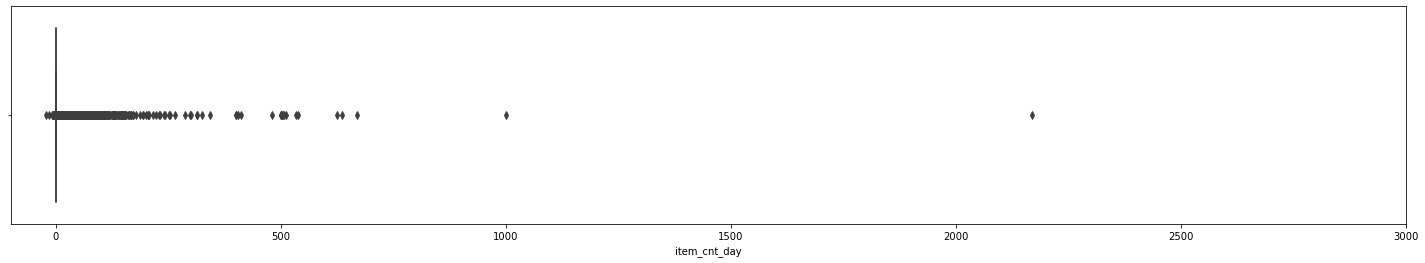

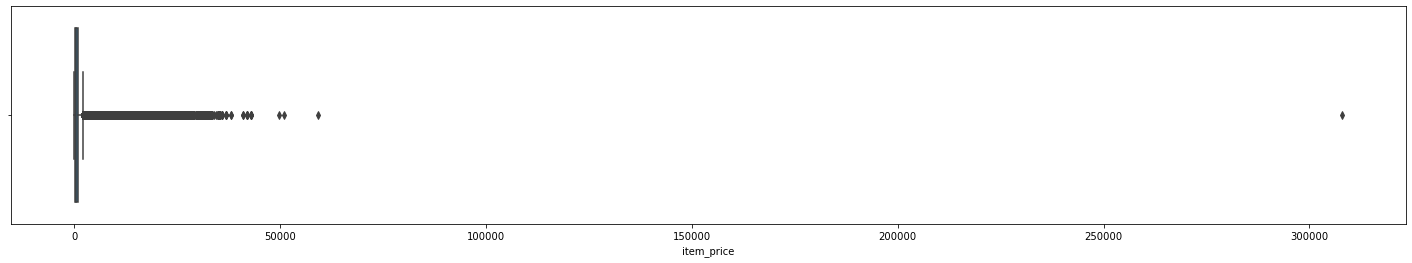

In [4]:
plt.figure(figsize = (25, 4))
plt.xlim(-100, 3000)
sns.boxplot(x = train.item_cnt_day)

plt.figure(figsize = (25, 4))
sns.boxplot(x = train.item_price)

We remove item counts and prices that are clearly outliers.

In [5]:
train = train[train.item_cnt_day < 1001]
train = train[train.item_price < 50000]

We also remove an item where item_price < 0.

In [6]:
train = train[train.item_price > 0]

There are duplicates of the shops' names, which we adjust for.

In [7]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

We remove shops that do not appear in the test set.

In [8]:
len(train[train['shop_id'].isin(test.shop_id.unique())]) / len(train)

0.8274540472858912

In [9]:
#train = train[train['shop_id'].isin(test.shop_id.unique())]

Add the first day the item was sold.

In [10]:
train['first_sale_day'] = train.date.dt.dayofyear 
train['first_sale_day'] += 365 * (train.date.dt.year-2013)
train['first_sale_day'] = train.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

Calculate the proportion of weekly sales that occurred on each weekday at each shop.

In [11]:
train['weekday'] = train.date.dt.dayofweek

temp = train.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, train.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on = 'shop_id', \
                how = 'left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales'] / temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum',\
                                                                        'first_day_of_month':'min'}).reset_index()

# Preprocessing of shops, categories and items

## Shops

In [12]:
shops.head()

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TC ""Oktyabr-Kinomir""",3
4,"Volga TC ""Volga Mall""",4


We start by cleaning up shop_names.

Each shop_name starts with the name of the city the shop is located in (with some exceptions). 
This information might be important.

We can also extract the shop_type from shop_name

In [13]:
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', '', regex = True)
shops['shop_name'] = shops['shop_name'].str.replace('sergiev posad', 'sergievposad')
shops['shop_name'] = shops['shop_name'].str.replace('st petersburg', 'stpetersburg')
shops['shop_name'] = shops['shop_name'].str.replace('rostovnadonu', 'rostovnadon')
shops['shop_name'] = shops['shop_name'].str.strip()

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['category'] = 'regular'

shops.loc[shops['shop_name'].str.contains(r'tc'), 'category'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'category'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'category'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'category'] = 'online'

shops.loc[shops['shop_id'].isin([12,55]), 'city'] = 'online'

shops.head()

,shop_name,shop_id,city,category
0,yakutsk ordzhonikidze 56 francs,0,yakutsk,regular
1,yakutsk tc central fran,1,yakutsk,tc
2,adygea tc mega,2,adygea,mall
3,balashikha tc oktyabrkinomir,3,balashikha,tc
4,volga tc volga mall,4,volga,mall


In [14]:
#plt.figure(figsize = (30, 10))
#sns.countplot(x = 'category', data = shops)

We only keep a category if there are 5 or more shops of that category, otherwise we set 'Other'.

In [15]:
#categories = []
#for cat in shops.category.unique():
#    if len(shops[shops.category == cat]) >= 5:
#        categories.append(cat)
#shops.category = shops.category.apply(lambda x: x if (x in categories) else 'Other')

In [16]:
#plt.figure(figsize = (30, 10))
#g = sns.countplot(x = 'city', data = shops)
#g.set_xticklabels(g.get_xticklabels(), rotation = 45)
#None

One city (Moscow) is found much more frequently than the others.

We only keep a city if there are 2 or more of them. 

**Note:** In the early xgb models we've trained, city_code was not used as a feature at all, so it's worth trying.

In [17]:
#shops[['city_code', 'category_code']] = OrdinalEncoder().fit_transform(shops[['city', 'category']])

In [18]:
#shops

In [19]:
#cities = []
#for city in shops.city.unique():
#    if len(shops[shops.city == city]) >= 2:
#        cities.append(city)
#shops.city = shops.city.apply(lambda x: x if (x in cities) else 'Other')

#shops["category_code"] = OrdinalEncoder().fit_transform(shops.category.values.reshape(1, -1))[0]
#shops["city_code"] = OrdinalEncoder().fit_transform(shops.city.values.reshape(1, -1))[0]

shops[['city_code', 'category_code']] = OrdinalEncoder().fit_transform(shops[['city', 'category']])

shops = shops[["shop_id", "category_code", "city_code"]]

shops.head()

,shop_id,category_code,city_code
0,0,2.0,27.0
1,1,4.0,27.0
2,2,0.0,0.0
3,3,4.0,1.0
4,4,0.0,24.0


## Categories

In [20]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Each category contains a type and subtype (with some exceptions). We also perform some cleaning

In [21]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip()) # All leading and trailing
# whitespaces are removed from the string
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
# If subtype is not available we set type as subtype.

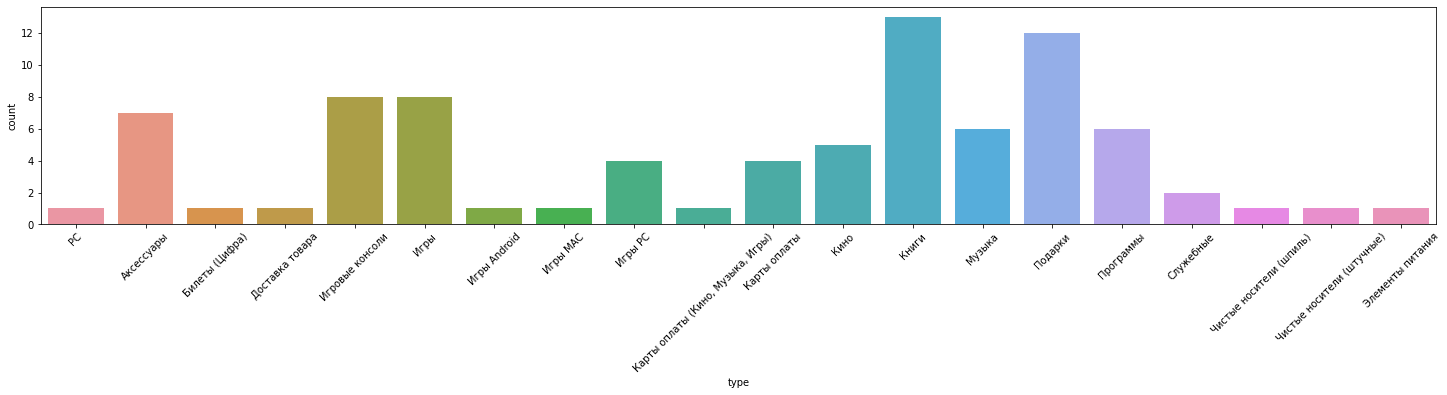

In [22]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = 'type', data = item_categories)
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
None

We only keep a type if there are 5 or more of them. From the feature importances of the models we've already trained we know that this is not a very important feature, so binning might improve it.

In [23]:
types = []
for my_type in item_categories.type.unique():
    if len(item_categories[item_categories.type == my_type]) >= 5: 
        types.append(my_type)
item_categories.type = item_categories.type.apply(lambda x: x if (x in types) else "Other")

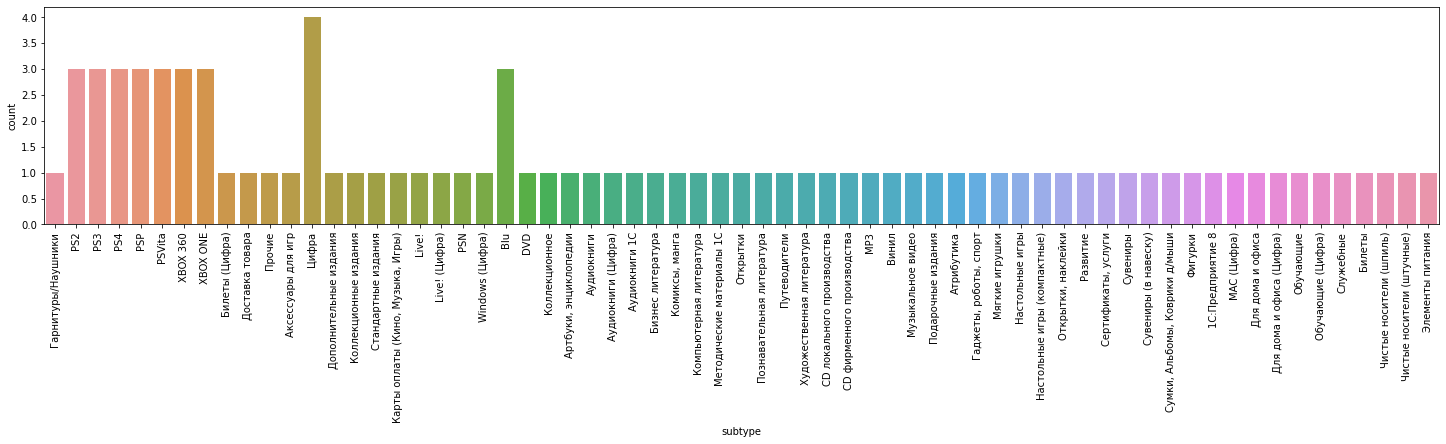

In [24]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = 'subtype', data = item_categories)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
None

From the models we have trained previously we can see that subtype is already quite important as a feature, so we leave it as it is.

In [25]:
#item_categories['type_code'] = OrdinalEncoder().fit_transform(item_categories.type.values.reshape(1, -1))[0]
#item_categories['subtype_code'] = OrdinalEncoder().fit_transform(item_categories.subtype.values.reshape(1, -1))[0]

item_categories[['type_code', 'subtype_code']] = OrdinalEncoder().fit_transform(item_categories[['type', \
                                                                                                 'subtype']])

item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0.0,29.0
1,1,1.0,9.0
2,2,1.0,10.0
3,3,1.0,11.0
4,4,1.0,13.0


## Items

In [26]:
items.head()

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D


We will do some corrections of item_name.

In [27]:
def name_correction(x):
    x = x.lower() # Make all letters lower case.
    x = x.partition('[')[0] # Partition by square brackets.
    x = x.partition('(')[0] # Partition by curly brackets.
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # Remove special characters.
    x = x.replace('  ', ' ') # Replace double spaces with single spaces.
    x = x.strip() # Remove leading and trailing white space.
    x = x.replace('.', '')
    return x

Split item_name into two parts (depending on which type of bracket is found).

In [28]:
items[["item_name1", "item_name2"]] = items.item_name.str.split("[", 1, expand = True)
items[["item_name1", "item_name3"]] = items.item_name.str.split("(", 1, expand = True)

items["item_name2"] = items.item_name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ", regex = True).str.lower()
items["item_name3"] = items.item_name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ", regex = True).str.lower()

items = items.fillna('0')

Clean and simplify item_name, and create a new feature consisting of the first eleven characters of the string.

In [29]:
items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b', r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',r'\bto\b',
          r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ', regex = True)
    
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ', regex = True)

items['item_name_no_space'] = items['item_name'].str.replace(' ', '')

items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]

#items['item_name_first11'] = OrdinalEncoder().fit_transform(items['item_name_first11'].values.reshape(-1, 1))

del items['item_name_no_space']

items.head()

,item_id,category_id,item_name,item_name1,item_name2,item_name3,item_name_first11
0,0,40,power happiness,!! IN THE POWER OF HAPPINESS,0,plast d,powerhappin
1,1,76,abbyy finereader 12 professional edition full,! ABBYY FineReader 12 Professional Edition Ful...,pc digital version,0,abbyyfinere
2,2,40,glory glory,*** IN THE GLORY OF THE GLORY,0,unv d,gloryglory
3,3,40,blue wave,*** BLUE WAVE,0,univ d,bluewave
4,4,40,box,*** BOX,0,glass d,box


Set type column and clean it.

In [30]:
items["type"] = items.item_name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") , "type"] = "xbox 360"
items.loc[items.type == "", "type"] = "mac"
items.type = items.type.apply(lambda x: x.replace(" ", ""))
items.loc[(items.type == 'pc' ) | (items.type == 'pс') | (items.type == "pc"), "type"] = "pc"
items.loc[items.type == 'рs3', "type"] = "ps3"

'0' and 'pc' occur much more frequently than the other categories, so we don't plot them.

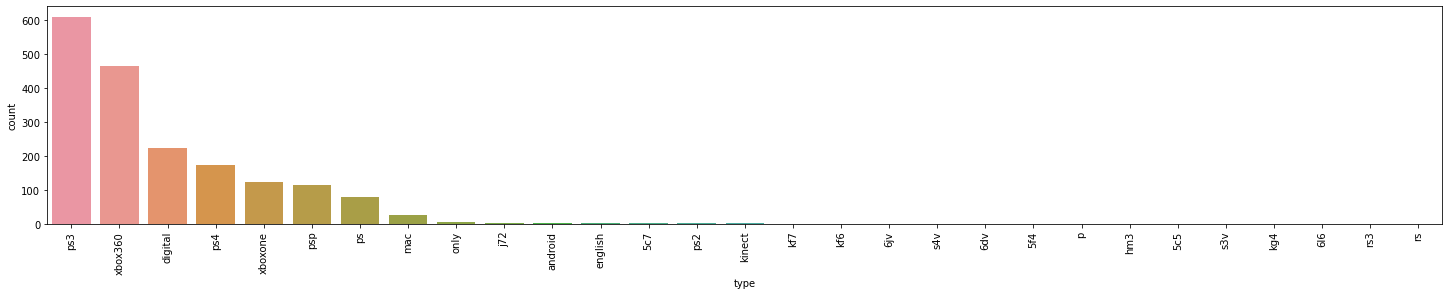

In [31]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = "type", data = items[~items.type.isin(["0", "pc"])], \
                  order = items[~items.type.isin(["0", "pc"])]['type'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
None

We only consider types that occur more than 40 times.

In [32]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cats = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <= 40:
        drop_cats.append(cat)
items.item_name2 = items.item_name2.apply(lambda x: "Other" if (x in drop_cats) else x )
items = items.drop(["type"], axis = 1)

#items.item_name2 = OrdinalEncoder().fit_transform(items.item_name2.values.reshape(1, -1))[0]
#items.item_name3 = OrdinalEncoder().fit_transform(items.item_name3.values.reshape(1, -1))[0]

items[['item_name2', 'item_name3', 'item_name_first11']] = OrdinalEncoder().\
fit_transform(items[['item_name2', 'item_name3', 'item_name_first11']])

items = items.drop(["item_name", "item_name1"], axis = 1)

items.head()

,item_id,category_id,item_name2,item_name3,item_name_first11
0,0,40,2.0,1315.0,7822.0
1,1,76,46.0,37.0,230.0
2,2,40,2.0,1641.0,4236.0
3,3,40,2.0,1640.0,1445.0
4,4,40,2.0,960.0,1619.0


# Monthly aggregation of data and feature engineering

Add revenue as a feature.

In [33]:
train['revenue'] = train['item_cnt_day'] * train['item_price']

Consider all possible pairs of item/shop in each date_block_num.

In [34]:
index_cols = ['date_block_num', 'shop_id', 'item_id']

# For every month we create a grid for all shop/item combinations from that month.
grid = [] 
ts = time.time()
for block_num in train['date_block_num'].unique():
    cur_shops = train[train['date_block_num'] == block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num'] == block_num]['item_id'].unique()
    grid.append(np.array(list(product([block_num], cur_shops, cur_items)), dtype = 'int16'))

# Turn the grid into a pandas dataframe.
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = np.int32)

grid.sort_values(index_cols, inplace = True)
time.time() - ts

9.144834756851196

Adjust the test set - add date_block_num = 34 (November 2015).

In [35]:
test["date_block_num"] = 34

Concatenate train and test sets to make it easier to add features.

In [36]:
grid = pd.concat([grid, test.drop("ID", axis = 1)], ignore_index = True, sort = False, keys = index_cols)

## Add shops, items and item_categories features.

Add features related to the id of shops, items and categories.

In [37]:
ts = time.time()
grid = pd.merge(grid, shops, on = ['shop_id'], how = 'left')
grid = pd.merge(grid, items, on = ['item_id'], how = 'left')
#grid = pd.merge(grid, item_categories, on = ['item_category_id'], how = 'left')
grid = pd.merge(grid, item_categories, left_on = 'category_id', right_on = 'item_category_id', how = 'left')
time.time() - ts

2.582657814025879

We also add features from the dataframe dates.

In [38]:
grid = pd.merge(grid, dates.drop('month', axis = 1), on = ['date_block_num','shop_id'], how = 'left')

## Add first_sale_day and prev_days_on_sale

In [39]:
ts = time.time()
train_monthly = train.groupby(index_cols).agg({'first_sale_day':['first']})
train_monthly.columns = ['first_sale_day']
train_monthly = train_monthly.reset_index()
grid = pd.merge(grid, train_monthly, on = index_cols, how = "left").fillna(0)
time.time() - ts

5.423037528991699

In [40]:
ts = time.time()
grid['first_sale_day'] = grid.groupby('item_id')['first_sale_day'].transform('max').astype('int16')
grid.loc[grid['first_sale_day'] == 0, 'first_sale_day'] = 1035 # first_day_of_month for date_block_num = 34
grid['prev_days_on_sale'] = [max(idx) for idx in zip(grid['first_day_of_month'] - grid['first_sale_day'], \
                                                     [0] * len(grid))]
del grid['first_day_of_month']
time.time() - ts

4.649478912353516

## Target variable and target lags

Obtain the target.

In [41]:
ts = time.time()
train_monthly = train.groupby(index_cols).agg({'item_cnt_day':['sum']})
train_monthly.columns = ['item_cnt_month_shop_item']
train_monthly = train_monthly.reset_index()
grid = pd.merge(grid, train_monthly, on = index_cols, how = "left" )
time.time() - ts

4.64244532585144

Fill NaNs with 0 in the target and clip to the range [0, 20] (the range that will be considered on evaluation).

In [42]:
grid['item_cnt_month_shop_item'] = grid['item_cnt_month_shop_item'].fillna(0).clip(0,20)

Define the function we use to get lagged values of relevant aggregated quantities and the lags we will use (in general).

In [43]:
def lag_feature(df, lags, cols):
    for col in cols:
        print('Adding lagged feature(s) for:', col)
        tmp = df[index_cols + [col]]
        for i in lags:
            shifted = tmp.copy()            
            shifted.columns = index_cols + [col + "_lag_" + str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on = index_cols, how = 'left')
    return df

lags = [1, 2, 3]

Add lags of the target.

In [44]:
ts = time.time()
grid = lag_feature(grid, lags, ['item_cnt_month_shop_item'])
time.time() - ts

Adding lagged feature(s) for: item_cnt_month_shop_item


16.313982009887695

Downcast to save memory.

In [45]:
def downcast(df):
    for col in grid.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype(np.int16)
        if df[col].dtype == 'float64':
            df[col] = df[col].astype(np.float16)
    return(df)

grid = downcast(grid)

## Add cluster of shops and shop_type

Cluster the shops based on the proportion of the sales they make in each category.

In [46]:
shops_cats = pd.DataFrame(
    np.array(list(product(*[grid['shop_id'].unique(), grid['category_id'].unique()]))),
    columns = ['shop_id', 'category_id']
)
temp = grid.groupby(['category_id', 'shop_id']).agg({'item_cnt_month_shop_item':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt_month_shop_item':'sum'}).rename(columns = {'item_cnt_month_shop_item':'shop_total'})
temp = temp.join(temp2, on = 'shop_id')
temp['category_proportion'] = temp['item_cnt_month_shop_item'] / temp['shop_total']
temp = temp[['shop_id', 'category_id', 'category_proportion']]
shops_cats = pd.merge(shops_cats, temp, on = ['shop_id', 'category_id'], how = 'left')
shops_cats = shops_cats.fillna(0)

shops_cats = shops_cats.pivot(index = 'shop_id', columns = ['category_id'])
kmeans = KMeans(n_clusters = 7, random_state = 0).fit(shops_cats)
shops_cats['shop_cluster'] = kmeans.labels_.astype('int8')

shops = shops.join(shops_cats['shop_cluster'], on = 'shop_id')

## Mean encoded features

Add aggregated values for date_block_num, shop_id and item_id (index_cols).

In [47]:
ts = time.time()
train_monthly = train.groupby(index_cols).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum'], })
train_monthly.columns = ['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = index_cols, how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item'])

grid = grid.drop(['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_price_month_shop_item_mean
Adding lagged feature(s) for: revenue_month_shop_item


50.38040328025818

**Note:** We must drop item_cnt_month_shop_item_mean, item_price_month_shop_item_mean and revenue_month_shop_item, otherwise we have data leakage (information extracted from the target is contained in a feature). item_cnt_month_shop_item is our target, so we keep it for now.

In [48]:
grid = downcast(grid)

Add aggregated values for date_block_num and shop_id.

In [49]:
ts = time.time()
train_monthly = train.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum']})
train_monthly.columns = ['item_cnt_month_shop_mean',  'item_price_month_shop_mean', 'revenue_month_shop']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num', 'shop_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_mean', 'item_price_month_shop_mean', 'revenue_month_shop'])

grid = grid.drop(['item_cnt_month_shop_mean', 'item_price_month_shop_mean', 'revenue_month_shop'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_price_month_shop_mean
Adding lagged feature(s) for: revenue_month_shop


54.913445234298706

In [50]:
grid = downcast(grid)

Add aggregated values for date_block_num and item_id.

In [51]:
ts = time.time()
train_monthly = train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum']})
train_monthly.columns = ['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num', 'item_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item'])

grid = grid.drop(['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_price_month_item_mean
Adding lagged feature(s) for: revenue_month_item


62.302067279815674

In [52]:
grid = downcast(grid)

Add aggregated values only for date_block_num.

In [53]:
ts = time.time()
train_monthly = train.groupby('date_block_num').agg({'item_cnt_day':['mean']})
train_monthly.columns = ['item_cnt_month_mean']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_mean'])

grid = grid.drop('item_cnt_month_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_mean


26.812099933624268

In [54]:
grid = downcast(grid)

Add aggregated values for date_block_num and item_category_id.

In [55]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_item_cat_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'item_category_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_cat_mean'])

grid = grid.drop('item_cnt_month_item_cat_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_cat_mean


29.20666003227234

In [56]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and item_category_id.

In [57]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_item_cat_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'item_category_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_item_cat_mean'])

grid = grid.drop('item_cnt_month_shop_item_cat_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean


30.863685607910156

In [58]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and type_code.

In [59]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_type_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'type_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_type_code_mean'])

grid = grid.drop('item_cnt_month_shop_type_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean


32.67710065841675

In [60]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and subtype_code.

In [61]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_subtype_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'subtype_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_subtype_code_mean'])

grid = grid.drop('item_cnt_month_shop_subtype_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean


33.71464014053345

In [62]:
grid = downcast(grid)

Add aggregated values for date_block_num and city_code.

In [63]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_city_code_mean'])

grid = grid.drop('item_cnt_month_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_city_code_mean


34.493595123291016

In [64]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and city_code.

In [65]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_city_code_mean'])

grid = grid.drop('item_cnt_month_shop_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean


35.820948362350464

In [66]:
grid = downcast(grid)

Add aggregated values for date_block_num, item_id and city_code.

In [67]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_item_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'item_id', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_city_code_mean'])

grid = grid.drop('item_cnt_month_item_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_city_code_mean


41.88607597351074

In [68]:
grid = downcast(grid)

Add aggregated values for date_block_num and type_code.

In [69]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_type_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'type_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_type_code_mean'])

grid = grid.drop('item_cnt_month_type_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_type_code_mean


37.928889989852905

In [70]:
grid = downcast(grid)

Add aggregated values for date_block_num and subtype_code.

In [71]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_subtype_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'subtype_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_subtype_code_mean'])

grid = grid.drop('item_cnt_month_subtype_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_subtype_code_mean


39.128056049346924

In [72]:
grid = downcast(grid)

## Trend related features

Add global average item_price (for train data), use lag values of item_price per month and add delta price values (how the current month's average price relates to the global average).

In [73]:
ts = time.time()
train_agg = train[train['date_block_num'] < 33].groupby(['item_id']).agg({'item_price': ['mean']}) # In order to 
# avoid data leakage we exclude the validation period.
train_agg.columns = ['item_price_item_mean']
train_agg = train_agg.reset_index()

grid = grid.merge(train_agg, on = ['item_id'], how = "left")

for i in lags:
    grid['delta_price_lag_' + str(i) ] = (grid['item_price_month_item_mean_lag_' + str(i)] - \
                                          grid['item_price_item_mean']) / grid['item_price_item_mean']
    
def select_trends(row): # Choose the first NaN value.
    for i in lags:
        if ~np.isnan(row["delta_price_lag_" + str(i)]):
            return row["delta_price_lag_" + str(i)]
    return 0

grid = downcast(grid)

grid['delta_price_lag'] = grid.apply(select_trends, axis = 1)
grid['delta_price_lag'] = grid['delta_price_lag'].fillna(-999) # Let's try this and see if it works.

features_to_drop = ['item_price_item_mean']
for i in lags:    
    features_to_drop += ['delta_price_lag_' + str(i)]

grid.drop(features_to_drop, axis=1, inplace=True)
time.time()- ts

155.98460388183594

**Note:** For the test data, item_price_item_mean should be calculated for the entire time period (train + val) if we are to be completely consistent.

In [74]:
grid = downcast(grid)

Add delta revenue values (how the last month's revenue relates to the global average)

In [75]:
ts = time.time()
train_agg = train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
train_agg.columns = ['revenue_month_shop']
train_agg = train_agg.reset_index()

grid = pd.merge(grid, train_agg, on=['date_block_num','shop_id'], how='left')

train_agg = train[train['date_block_num'] < 33].groupby(['shop_id']).agg({'revenue': ['mean']})
train_agg.columns = ['revenue_shop_mean']
train_agg = train_agg.reset_index()

grid = grid.merge(train_agg, on = ['shop_id'], how = "left")

grid['delta_revenue'] = (grid['revenue_month_shop'] - grid['revenue_shop_mean']) / grid['revenue_month_shop']

grid = downcast(grid)

grid = lag_feature(grid, [1], ['delta_revenue']) # Only consider one lag here.

features_to_drop = ['revenue_month_shop', 'revenue_shop_mean', 'delta_revenue']
grid.drop(features_to_drop, axis=1, inplace=True)
time.time()- ts

Adding lagged feature(s) for: delta_revenue


30.895984411239624

In [76]:
grid = downcast(grid)

## Special features

Add the number of the month as a feature.

In [77]:
grid['month'] = grid['date_block_num'] % 12

Add the number of days in the month (no leap years).

In [78]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
grid['no_days_in_month'] = grid['month'].map(days)

In [79]:
grid = downcast(grid)

Add the number of months since the last sale for each shop/item pair.

In [80]:
ts = time.time()
cache = {}
grid['item_shop_last_sale'] = -999 
for row in grid.itertuples():
    idx = getattr(row,'Index')
    item_id = getattr(row,'item_id')
    shop_id = getattr(row,'shop_id')
    date_block_num = getattr(row,'date_block_num')
    item_cnt_month_shop_item = getattr(row,'item_cnt_month_shop_item')
    key = str(item_id)+' '+str(shop_id)
    if key not in cache:
        if item_cnt_month_shop_item!=0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        grid.at[idx, 'item_shop_last_sale'] = date_block_num - last_date_block_num
        cache[key] = date_block_num
time.time() - ts

143.13822054862976

Add number of months since the last sale for each item.

In [81]:
ts = time.time()
cache = {}
grid['item_last_sale'] = -999 
for row in grid.itertuples():
    idx = getattr(row,'Index')
    item_id = getattr(row,'item_id')    
    date_block_num = getattr(row,'date_block_num')
    item_cnt_month_shop_item = getattr(row,'item_cnt_month_shop_item')
    key = str(item_id)
    if key not in cache:
        if item_cnt_month_shop_item!=0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        grid.at[idx, 'item_last_sale'] = date_block_num - last_date_block_num
        cache[key] = date_block_num
time.time() - ts

208.5228555202484

Add number of months since the first sale for each shop/item pair, and only item respectively.

In [82]:
ts = time.time()
grid['item_shop_first_sale'] = grid['date_block_num'] - grid.groupby(['item_id','shop_id'])['date_block_num']\
.transform('min')
grid['item_first_sale'] = grid['date_block_num'] - grid.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.287583827972412

In [83]:
grid = downcast(grid)

## Final preparation

Replace any eventual infinite values with 0.

In [84]:
grid = grid.replace(np.inf, 0)

Delete the first three months from grid as they definitely do not have any lag values.

In [85]:
grid = grid[grid["date_block_num"] > (len(lags) - 1)]

In [86]:
grid.isnull().sum(axis = 0)

date_block_num                                       0
shop_id                                              0
item_id                                              0
category_code                                        0
city_code                                            0
category_id                                          0
item_name2                                           0
item_name3                                           0
item_name_first11                                    0
item_category_id                                     0
type_code                                            0
subtype_code                                         0
year                                                 0
day_quality                                          0
first_sale_day                                       0
prev_days_on_sale                                    0
item_cnt_month_shop_item                             0
item_cnt_month_shop_item_lag_1                 1663973
item_cnt_m

Fill NaNs in lag features with 0.

In [87]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):            
            if ('item_cnt' in col) or ('revenue' in col): # If it's valid for item_cnt, it should be valid for 
                # revenue as well since revenue = item_cnt * price.
                df[col].fillna(0, inplace = True)
            if ('item_price_month_shop_item_mean_lag_' in col) or ('item_price_month_shop_mean_lag_' in col) or \
            ('item_price_month_item_mean_lag_' in col):
                df[col].fillna(-999, inplace = True) # It doesn't make sense to fill price related lag features \
                # with 0.
                
    return df

grid = fill_na(grid)
time.time() - ts

4.696542739868164

In [88]:
grid.isnull().sum(axis = 0)

date_block_num                                 0
shop_id                                        0
item_id                                        0
category_code                                  0
city_code                                      0
category_id                                    0
item_name2                                     0
item_name3                                     0
item_name_first11                              0
item_category_id                               0
type_code                                      0
subtype_code                                   0
year                                           0
day_quality                                    0
first_sale_day                                 0
prev_days_on_sale                              0
item_cnt_month_shop_item                       0
item_cnt_month_shop_item_lag_1                 0
item_cnt_month_shop_item_lag_2                 0
item_cnt_month_shop_item_lag_3                 0
item_cnt_month_shop_

In [89]:
data = grid.copy()
del grid
gc.collect()

139

Save the data in a pickle file.

In [90]:
data.to_pickle('data.pkl')